In [1]:
!git clone https://github.com/ManchesterBioinference/GPcounts.git

Cloning into 'GPcounts'...
remote: Enumerating objects: 19803, done.
remote: Counting objects: 100% (401/401), done.
remote: Compressing objects: 100% (264/264), done.
remote: Total 19803 (delta 147), reused 378 (delta 137), pack-reused 19402
Receiving objects: 100% (19803/19803), 369.67 MiB | 12.57 MiB/s, done.
Resolving deltas: 100% (12656/12656), done.
Updating files: 100% (192/192), done.


In [2]:
#You have to modify the requirements.txt file and change the gpflow version to 2.5.2. Otherwise later code fails.
%cd /content/GPcounts
!pip install -r requirements.txt
%cd ..

/content/GPcounts
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.9/383.9 KB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 KB 9.2 MB/s eta 0:00:00
/content


In [3]:
!pip install git+https://github.com/markvdw/RobustGP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/markvdw/RobustGP.git to /tmp/pip-req-build-4ti3xdpl
  Running command git clone --filter=blob:none --quiet https://github.com/markvdw/RobustGP.git /tmp/pip-req-build-4ti3xdpl
  Resolved https://github.com/markvdw/RobustGP.git to commit 0819bc9370f8e974f7f751143224d59d990e9531
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.8/115.8 KB 5.3 MB/s eta 0:00:00
  Created wheel for robustgp: filename=robustgp-0.0.2-py3-none-any.whl size=48552 sha256=07df8b26bf460d9a922eb49f90659bf2c8bb3b01c9798a5a46d39d60c8da5376
  Stored in directory: /tmp/pip-ephem-wheel-cache-w3u3fqaw/wheels/70/de/ab/f893e04def50393493897cbbe0373590550e02802deddaa176
Successfully built robustgp


In [4]:
%cd /content/GPcounts
!python setup.py install
%cd ..

/content/GPcounts
/usr/lib/python3.8/distutils/dist.py:274: UserWarning: Unknown distribution option: 'install_requires'
  warnings.warn(msg)
running install
running build
running build_py
creating build
creating build/lib
creating build/lib/GPcounts
copying GPcounts/NegativeBinomialLikelihood.py -> build/lib/GPcounts
copying GPcounts/__init__.py -> build/lib/GPcounts
copying GPcounts/GPcounts_Module.py -> build/lib/GPcounts
copying GPcounts/branchingKernel.py -> build/lib/GPcounts
running install_lib
creating /usr/local/lib/python3.8/dist-packages/GPcounts
copying build/lib/GPcounts/NegativeBinomialLikelihood.py -> /usr/local/lib/python3.8/dist-packages/GPcounts
copying build/lib/GPcounts/__init__.py -> /usr/local/lib/python3.8/dist-packages/GPcounts
copying build/lib/GPcounts/GPcounts_Module.py -> /usr/local/lib/python3.8/dist-packages/GPcounts
copying build/lib/GPcounts/branchingKernel.py -> /usr/local/lib/python3.8/dist-packages/GPcounts
byte-compiling /usr/local/lib/python3.8/dist

In [5]:
import pandas as pd 
import numpy as np 
import gpflow
import tensorflow as tf
from GPcounts.GPcounts_Module import Fit_GPcounts
from matplotlib import pyplot as plt


###Load data

In [6]:
# spatial expression counts matrix
Y = pd.read_csv('/content/GPcounts/data/MouseOB/Rep11_MOB_0.csv', index_col=[0])
Y = Y.T[Y.sum(0) >= 3].T # Filter out genes with less than 3 total counts
Y.head()

,Nrf1,Zbtb5,Ccnl1,Lrrfip1,Bbs1,Lix1,Whrn,Ate1,Ubac1,Rab34,...,Mertk,Snord19,1500002O10Rik,Gm5105,H2-Bl,Mir384,Snord91a,Zdhhc23,Fam150a,Hist4h4
16.92x9.015,1,1,1,2,1,2,1,1,2,1,...,0,0,0,0,0,0,0,0,0,0
16.945x11.075,0,0,3,2,2,7,0,2,3,2,...,0,0,0,0,0,0,0,0,0,0
16.97x10.118,0,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16.939x12.132,1,0,1,0,4,6,1,4,3,1,...,0,0,0,0,0,0,0,0,0,0
16.949x13.055,0,0,0,3,0,2,0,2,4,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
spatial_locations = pd.DataFrame(index=Y.index)
spatial_locations['x'] = Y.index.str.split('x').str.get(0).map(float)
spatial_locations['y'] = Y.index.str.split('x').str.get(1).map(float)


In [8]:
spatial_locations['total_counts'] = Y.sum(1)
Y = Y.loc[spatial_locations.index]
X = spatial_locations[['x', 'y']]
scale = pd.read_csv('/content/GPcounts/data/MouseOB/scales_nb.txt', sep="\t") # load the file with the scale factors 


After filtering, the whole data-set contains 14,859 genes but for simplicity we run this example on the first 20 genes. This will take a few minutes. For the purposes of comparison, we provide a file (../data/MouseOB/SE_genes_comparison.csv) with the all spatially expressed genes found by running GPcounts on the whole data-set as well as the spatially expressed genes identified by SpatialDE package.



In [10]:
Y = Y.T
Y_run = Y.iloc[0:20,:] # select first 20 genes to run GPcounts
X = X[['x', 'y']]


###To run the scaled version of the GPcounts, where the negative binomial mean is multiplied by the pre-culculated scale factors, we should use the optional argument in the function Fit_GPcounts: 'scale=scale'. The 'scale' argument contains the file with the scale factors.



In [11]:
gene_name = []
gene_name = Y_run.index
likelihood = 'Negative_binomial' 
gp_counts = Fit_GPcounts(X,Y_run.loc[gene_name], scale = scale,safe_mode=False)


###We run the One_sample_test with negative binomial likelihood for the 20 genes. The results will show the following:

####Name of the gene
####Dynamic_model_log_likelihood - Likelihood of the dynamic model
####Constant_model_log_likelihood - Likelihood of the constant ('null') model
####log_likelihood_ratio - Ratio between the dynamic and constant models
####p value - statistical significance based on P value
####q value - Statistical significance based on the "adjusted p value" for the false discovery rate or q value


In [12]:
log_likelihood_ratio = gp_counts.One_sample_test(likelihood)
log_likelihood_ratio


100%|██████████| 20/20 [14:38<00:00, 43.90s/it]


,Dynamic_model_log_likelihood,Constant_model_log_likelihood,log_likelihood_ratio
Nrf1,-2873.421365,-4989.720902,2116.299537
Zbtb5,-3003.917568,-5287.834004,2283.916436
Ccnl1,-6228.868554,-9741.714854,3512.846301
Lrrfip1,-4890.110145,-8527.434046,3637.323901
Bbs1,-4974.808880,-7994.985617,3020.176736
Lix1,-8830.388308,-12852.330502,4021.942194
Whrn,-3740.798459,-6885.567845,3144.769386
Ate1,-6853.151188,-10385.216621,3532.065433
Ubac1,-7135.929917,-10636.412095,3500.482178
Rab34,-5040.360450,-8088.609391,3048.248942


In [13]:
results = gp_counts.calculate_FDR(log_likelihood_ratio)
results


,Dynamic_model_log_likelihood,Constant_model_log_likelihood,log_likelihood_ratio,p_value,q_value
Nrf1,-2873.421365,-4989.720902,2116.299537,0.000000,0.000000
Zbtb5,-3003.917568,-5287.834004,2283.916436,0.000000,0.000000
Ccnl1,-6228.868554,-9741.714854,3512.846301,0.000000,0.000000
Lrrfip1,-4890.110145,-8527.434046,3637.323901,0.000000,0.000000
Bbs1,-4974.808880,-7994.985617,3020.176736,0.000000,0.000000
Lix1,-8830.388308,-12852.330502,4021.942194,0.000000,0.000000
Whrn,-3740.798459,-6885.567845,3144.769386,0.000000,0.000000
Ate1,-6853.151188,-10385.216621,3532.065433,0.000000,0.000000
Ubac1,-7135.929917,-10636.412095,3500.482178,0.000000,0.000000
Rab34,-5040.360450,-8088.609391,3048.248942,0.000000,0.000000


####Plot some spatially expressed genes from the data-set based on the q values provided in file 'SE_genes_comparison.csv'



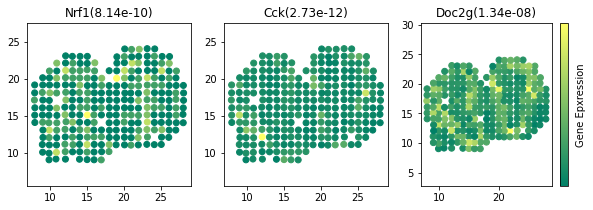

In [16]:
from matplotlib import rcParams
plt.rcParams["figure.figsize"] = [10,3]
m = ['Ptn(8.14e-10)', 'Cck(2.73e-12)', 'Doc2g(1.34e-08)']
for i, g in enumerate(['Ptn', 'Cck', 'Doc2g']):
    plt.subplot(1, 3, i + 1)
    plt.scatter(spatial_locations['x'], spatial_locations['y'], c=Y.T[g],cmap = 'summer')
    # plt.figure(figsize=(10,3))
    plt.title(m[i])
    plt.axis('equal')
plt.colorbar(ticks=[0,1],label = 'Gene Epxression')

plt.show()


####We plot two genes with very low expression which have been identified as spatially expressed by SpatialDE but not by GPcounts



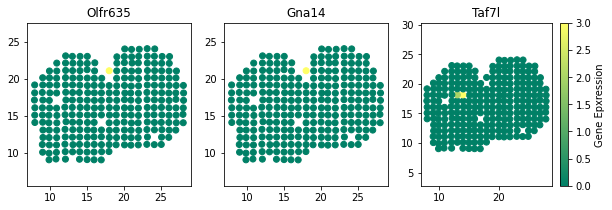

In [17]:
plt.rcParams["figure.figsize"] = [10,3]
n = ['Olfr635','Gna14', 'Taf7l']
for i, g in enumerate(['Olfr635','Gna14', 'Taf7l']):
    plt.subplot(1, 3, i + 1)
    plt.scatter(spatial_locations['x'], spatial_locations['y'], c=Y.T[g],cmap = 'summer')
    # plt.figure(figsize=(10,3))
    plt.title(n[i])
    plt.axis('equal')
plt.colorbar(label = 'Gene Epxression')
